In [10]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics.pairwise import cosine_similarity

In [11]:
dataset = load_dataset('glue','stsb',split='validation')
sentences1 = dataset['sentence1']
sentences2 = dataset['sentence2']

scores = np.array(dataset['label'])
scores

array([5.  , 4.75, 5.  , ..., 2.  , 0.  , 0.  ])

In [14]:
models = [
    "sentence-transformers/all-MiniLM-L6-v2",
    "sentence-transformers/all-MiniLM-L12-v2",
    "sentence-transformers/paraphrase-MiniLM-L6-v2",
    "sentence-transformers/all-mpnet-base-v2",
]

def evaluate_model(name):
    model=SentenceTransformer(name)
    start=time.time()

    embeddings1 = model.encode(sentences1, batch_size=32, show_progress_bar=True)
    embeddings2 = model.encode(sentences2, batch_size=32, show_progress_bar=True)

    end = time.time()

    inf_time = end - start

    cosine_scores = np.array([cosine_similarity([embeddings1[i]], [embeddings2[i]])[0][0] for i in range(len(embeddings1))])


    cosine_scaled=cosine_scores*5

    pearson_corr = pearsonr(cosine_scaled, scores)[0]
    spearman_corr = spearmanr(cosine_scaled, scores)[0]

    model_size=sum(p.numel() for p in model.parameters())*4/(1024**2)

    return pearson_corr, spearman_corr, inf_time, model_size

In [15]:
results=[]

for name in models:
    print('{name}:')
    pearson, spearman, time_taken, size = evaluate_model(name)

    results.append({
        'Model':name,
        'Pearson':pearson,
        'Spearman':spearman,
        'Time':time_taken,
        'Size(MB)':size,
    })

df=pd.DataFrame(results)
df

{name}:


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

{name}:


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

{name}:


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

{name}:


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

,Model,Pearson,Spearman,Time,Size(MB)
0,sentence-transformers/all-MiniLM-L6-v2,0.869619,0.867163,14.517330,86.644043
1,sentence-transformers/all-MiniLM-L12-v2,0.876909,0.874951,26.630946,127.258301
2,sentence-transformers/paraphrase-MiniLM-L6-v2,0.869475,0.870503,13.949697,86.644043
3,sentence-transformers/all-mpnet-base-v2,0.880625,0.881090,94.542118,417.657715


In [16]:
decision_matrix = df[['Pearson','Spearman','Time','Size(MB)']].values

norm_matrix = decision_matrix/np.sqrt((decision_matrix**2).sum(axis=0))

weights = np.array([0.3, 0.3, 0.2, 0.2])
weighted_mat = norm_matrix*weights

In [17]:
benefit=[0,1]
cost=[2,3]

ideal_best = np.zeros(weighted_mat.shape[1])
ideal_worst = np.zeros(weighted_mat.shape[1])

In [18]:
for i in range(weighted_mat.shape[1]):
    if i in benefit:
        ideal_best[i]=weighted_mat[:,i].max()
        ideal_worst[i]=weighted_mat[:,i].min()
    else:
        ideal_best[i]=weighted_mat[:,i].min()
        ideal_worst[i]=weighted_mat[:,i].max()

best_dist = np.sqrt(((weighted_mat-ideal_best)**2).sum(axis=1))
worst_dist = np.sqrt(((weighted_mat-ideal_worst)**2).sum(axis=1))

In [19]:
topsis_sc = worst_dist/(best_dist+worst_dist)

df['TOPSIS_score']=topsis_sc
df=df.sort_values(by='TOPSIS_score', ascending=False)

df

,Model,Pearson,Spearman,Time,Size(MB),TOPSIS_score
2,sentence-transformers/paraphrase-MiniLM-L6-v2,0.869475,0.870503,13.949697,86.644043,0.987992
0,sentence-transformers/all-MiniLM-L6-v2,0.869619,0.867163,14.517330,86.644043,0.985194
1,sentence-transformers/all-MiniLM-L12-v2,0.876909,0.874951,26.630946,127.258301,0.857349
3,sentence-transformers/all-mpnet-base-v2,0.880625,0.881090,94.542118,417.657715,0.013908


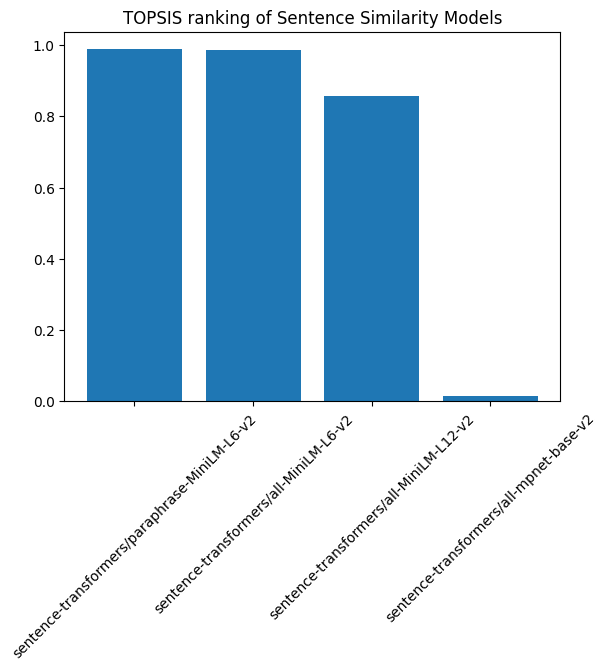

In [20]:
plt.figure()
plt.bar(df["Model"], df["TOPSIS_score"])
plt.xticks(rotation=45)
plt.title('TOPSIS ranking of Sentence Similarity Models')
plt.show()

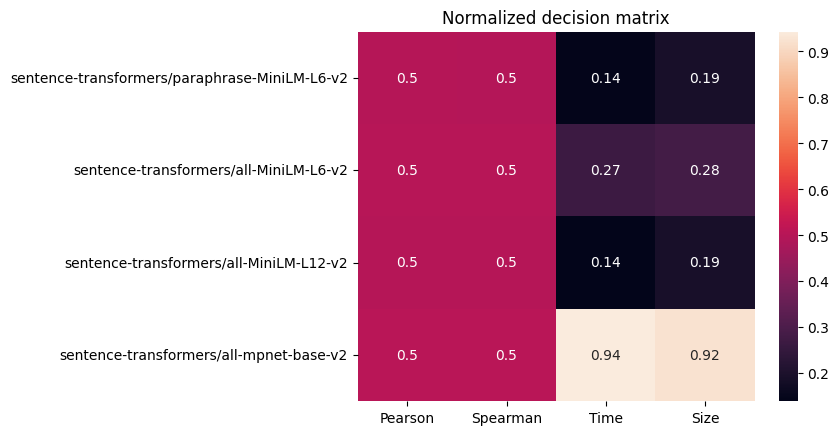

In [21]:
plt.figure()
sns.heatmap(norm_matrix, annot=True, xticklabels=['Pearson','Spearman','Time','Size'], yticklabels=df['Model'])
plt.title('Normalized decision matrix')
plt.show()